In [159]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__



'2.4.0+cu121'

### 1. Data Preparation and Loading
Data can be almost anything
* Excel
* Images
* Videos
* Text

DL is a game of two parts:
1. Get data into a numerical representations
2. Build a model to learn patterns in that numerical representation

To show this, let's create some *known* data using the linear regression formula.

We will use a linear regression formula to make a straight line with known **parameters**

In [160]:
# Create *known* parameters

weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets
let's create a training and test set with our data


In [161]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train),  len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!


In [162]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """ 
    Plots training data, test data and compare predictions.
    """

    plt.figure(figsize=(10,7))
    #plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")
    # plot testing data in green 
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    #Are there predictions
    if predictions is not None:
        #plot the predictions if they exist
        plt.scatter(test_data,predictions, c='r', s=4, label="Predictions")

    #show the legend
    plt.legend(prop={"size": 14});
    plt.show()


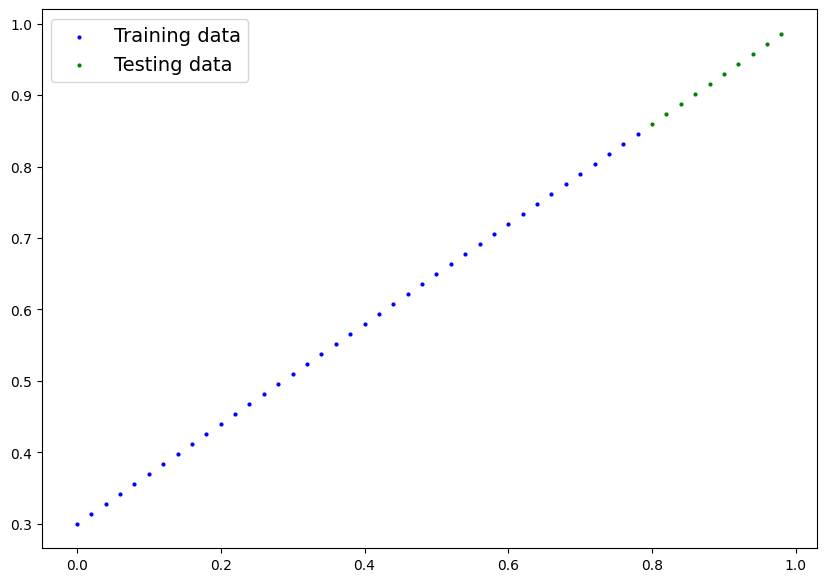

In [163]:
plot_predictions()

## 2. Build Model
our first pytorch model

what our model does:
* start with random values(weight & bias)
* look at the training data and adjust the random values to better represent(or get closer to) the ideal values

How does it do so?
Through two main algorithms
1. Gradient Descent
2. Back Propogation


In [164]:
# Create Linear regression model class
class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float32))
        # Forward method to define the computation in the model
    def forward(self,x:torch.Tensor) ->torch.Tensor:  # "x" is the input data
        return self.weights * x + self.bias
    

### PyTorch model building essentials
* torch.nn = contains all of the building blocks for computational graphs (another word for neural networks)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network models, if you subclass it, you should over-write forward()
* torch.optim =  this is where the optimizers in PyTorch live, they will help with gradient descent 
* def forward() - All nn.Module subclasses requires you to overwrite forward(), this method defines what happens in the forward method

* torch.utils.data.Dataset - Represents a map between key(label) and sample(features) pairs of your data. such as images and their associated lables
* torch.utils.data.DataLoader - Creates a Python iterable over a torch Dataset (allows you to iterate over your data)


### checking the contents of out PyTorch model
How we've created a model, let's see what's inside.....
so we can checkout model parameters or what's inside our model using '.parameters().


In [165]:
# create a random seed 
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model = LinearRegressionModel()

# check out the parameters
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [166]:
# list named parameters
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Mkaing predictions using torch.inference_mode()

To check our model's predictive power, let's see how well it predicts 'y_test' based on 'X_test'.
when we pass data through our model, it's going to run it through the forward() method


In [167]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [168]:
# make prediction with model
with torch.inference_mode():
    y_preds= model(X_test)

# You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred
# with torch.no_grad():
#     y_preds = model(X_test)

y_preds


tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

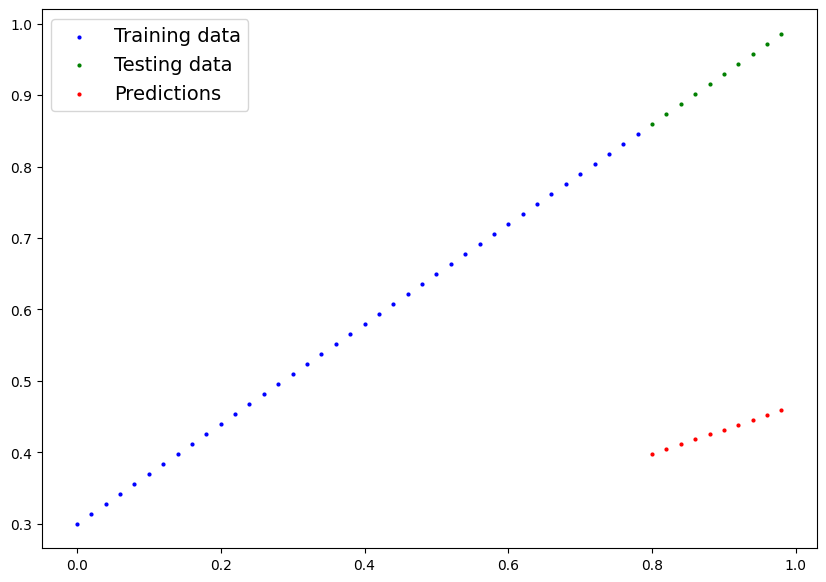

In [169]:
plot_predictions(predictions=y_preds)

### 3. Train model
The whole idea of training is for a model to move from some *unknown* parameters(these may be random) to some *known* parameters.
or in other words from a poor representation of the data to a better representation of the data

one way to measure how poor or how wrong your models predictions are is to use a loss function.
* Note: Loss functions/ cost functions/ criterion

Things we need to train:

** Loss function: ** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better
** Optimizer ** Takes into account the loss of a model and adjusts the model's parameters (e.g weight & bias) to improve the loss function
    Inside the optimizer you will often have to set two parameters:
        * params - the model parameters you would like to optimize for example params = model.parameters()
        * lr (Learning rate) - it is a hyperparameter that defines how big/small the optimizer changes the parameters with each step,
         (a small lr results in small change, a large lr results in large changes)

And specifically for Pytorch, we need:
* A training loop
* A testing loop


In [170]:
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [171]:
# check out our model's parameters (a parameter is a value that the model sets itself)
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [172]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer (Stochastic Gradient descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01) # lr- Learning rate =  possibly the most important hyperparameter you can set


### Building a training loop and a testing loop in pytorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass ( this involves the data moving through our model's forward() functions) to make predictions on data also called forward propogation
2. calculate the loss (compare forward pass predictions to the ground truth labels)
3. Optimizer zero grad
4. loss backward - moves backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropogation**)
5. Optimizer step - use the optimizer to adjust our model;s parameters to try and improve the loss (**gradient_descent**)




In [173]:
# An epoch is one loop through the data (This is a hyperparameter because we've set it ourselves)
epochs = 200
#Track different values
epoch_count = []
loss_values = []
test_loss_values = []

###Training
# 0. loop through the data

for epoch in range(epochs):
    #set the model to training mode
    model.train()  # train mode in PyTorch set all parameters that require gradients
    # 1. Forward pass
    y_pred = model(X_train)
    # 2. Calculate the Loss
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Perform backpropogation on the loss with respect to the parameters of the model
    loss.backward()
    # 5. step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 of the training loop

    ### Testing
    model.eval() # turns off different setting in the model not needed for evaluation/testing (like dropout, batch_norm)
    with torch.inference_mode(): # turns off gradient tracking & a couple of more things behind the scenes 
    # with torch.no_grad(): # you may also see torch.no_grad() in older pytorch code
        # 1. Do the forward pass
        test_pred = model(X_test)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:  
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss) 
        # Printout what's happening    
        print(f"Epoch: {epoch} | Loss : {loss} | Test_Loss: {test_loss}")
        # Printout model_state_dict
        print(model.state_dict())

        




Epoch: 0 | Loss : 0.31288138031959534 | Test_Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss : 0.1976713240146637 | Test_Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss : 0.08908725529909134 | Test_Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss : 0.053148526698350906 | Test_Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss : 0.04543796554207802 | Test_Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss : 0.04167863354086876 | Test_Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss : 0.03818932920694351 | Test_Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor(

In [174]:
import numpy as np
torch.tensor(loss_values).numpy()

array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

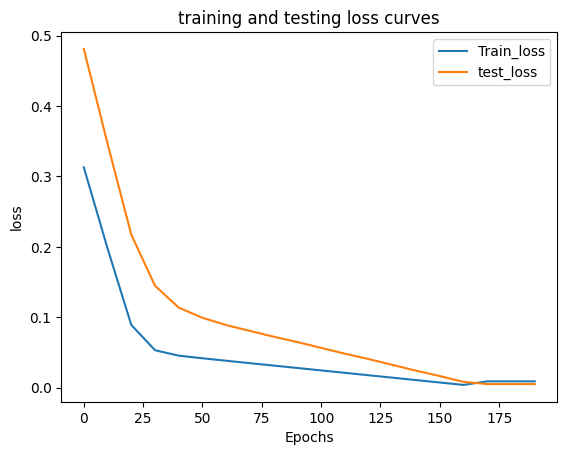

In [175]:
# Plot the loss curves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label = "Train_loss")
plt.plot(epoch_count, test_loss_values, label = "test_loss")
plt.title("training and testing loss curves")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()

In [176]:
with torch.inference_mode():
    y_pred_new = model(X_test)
    loss = loss_fn(y_pred_new, y_test)
    print(loss)
    

tensor(0.0084)


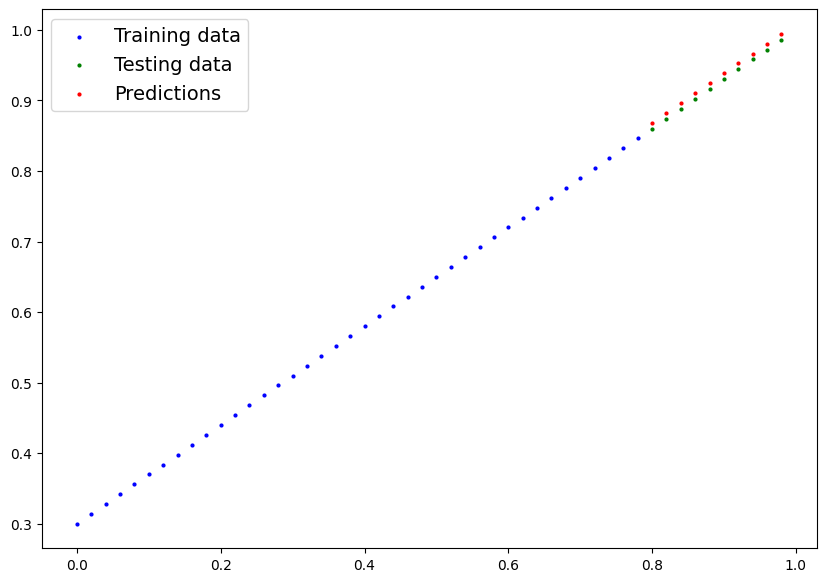

In [177]:
plot_predictions(predictions=y_pred_new)

## Saving a model in PyTorch
There are three main methods you should about for for saving and loading models in PyTorch.

1. 'torch.save()' - allows you save a PyTorch object in Python's pickle format
2. 'torch.load()' - allows you to load a saved PyTorch object
3. 'torch.nn.Module.load_state_dict()' - this allows to load a model's saved state dictionary

In [178]:
## Saving our PyTorch Model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME= "01_pytorch_workflow_mode.pth"
MODEL_SAVE_PATH= MODEL_PATH/MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(),
           f= MODEL_SAVE_PATH)



Saving model to: models/01_pytorch_workflow_mode.pth


In [179]:
!ls -l models

total 8
-rw-rw-r-- 1 nikhil nikhil 1662 Sep  7 14:41 01_pytorch_workflow_mode.pth
-rw-rw-r-- 1 nikhil nikhil 1744 Sep  4 19:23 01_pytorch_workflow_model_1.pth


## Loading a PyTorch model
Since we saved our model's 'state_dict()' rather than the entire model, we'll create a new instance of our model class and load the saved 'state_dict()' into that

In [180]:
# To load in a saved state_dict, we have to instantiate a new instance of our model class
loaded_model = LinearRegressionModel()


In [181]:
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [182]:
# Load the saved state dict of model (This will update the new instance with updated parameters)
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

/tmp/ipykernel_3785338/1946945710.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


<All keys matched successfully>

In [183]:
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [184]:
#make some predictions with our loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [185]:
loaded_model.eval()
with torch.inference_mode():
    model_preds = loaded_model(X_test)

model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [186]:
loaded_model_preds==model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together
let's go back through the steps above and see it all in one place


In [187]:
# Import PyTorch and Matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

#Check PyTorch version
torch.__version__

'2.4.0+cu121'

Create device-agnostic code.
This means that if we've got access to a GPU, our code will use it (for potentially faster computing)

If no GPU is available, the code will default to using CPU


In [188]:
# Setip device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [189]:
!nvidia-smi

Sat Sep  7 14:41:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           Off | 00000000:3B:00.0 Off |                    0 |
| N/A   57C    P0              41W / 250W |    752MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 6.1 Creating dataset

In [190]:

# Create *known* parameters

weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [191]:
# Splitting dataset
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train),  len(X_test), len(y_test)

(40, 40, 10, 10)

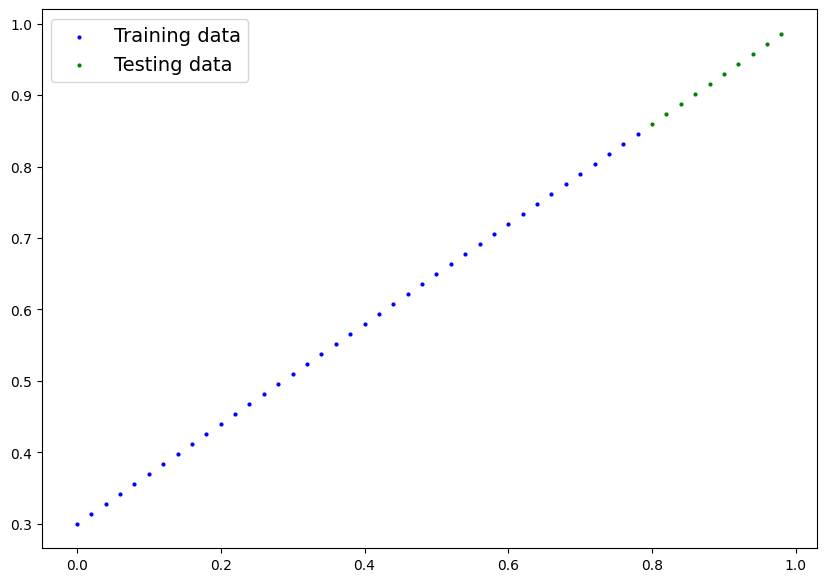

In [192]:
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [193]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self,x: torch.tensor) -> torch.Tensor: 
        x = self.linear_layer(x)
        return x
    
# set the manual seed 
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [194]:
# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [195]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device


device(type='cuda', index=0)

### 6.3 Training

for training we need:
* Loss Function
* Optimizer
* Training Loop
* Testing loop


In [196]:
# Setup Loss Funtion
loss_fn = nn.L1Loss() # Same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr=0.01)



In [197]:
# Let's write a training loop
torch.manual_seed(42)
epoch_values = []
train_loss_values = []
test_loss_values = []

# Put data on the target device  (Device agnostic code for data)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
epochs = 200
for epoch in range(epochs):
    # 1. Forward pass
    train_pred = model_1(X_train)
    # 2. Calculate the loss
    train_loss = loss_fn(train_pred,y_train)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
     # 4. Perform Backpropogation
    train_loss.backward()
    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch %10 ==0:
        print(f"Epochs: {epoch}, Train_Loss: {train_loss}, Test loss: {test_loss}")
        epoch_values.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
    
    


Epochs: 0, Train_Loss: 0.5551779866218567, Test loss: 0.5739762187004089
Epochs: 10, Train_Loss: 0.439968079328537, Test loss: 0.4392664134502411
Epochs: 20, Train_Loss: 0.3247582018375397, Test loss: 0.30455657839775085
Epochs: 30, Train_Loss: 0.20954833924770355, Test loss: 0.16984669864177704
Epochs: 40, Train_Loss: 0.09433845430612564, Test loss: 0.03513690456748009
Epochs: 50, Train_Loss: 0.023886388167738914, Test loss: 0.04784907028079033
Epochs: 60, Train_Loss: 0.019956795498728752, Test loss: 0.045803118497133255
Epochs: 70, Train_Loss: 0.016517987474799156, Test loss: 0.037530567497015
Epochs: 80, Train_Loss: 0.013089174404740334, Test loss: 0.02994490973651409
Epochs: 90, Train_Loss: 0.009653178043663502, Test loss: 0.02167237363755703
Epochs: 100, Train_Loss: 0.006215683650225401, Test loss: 0.014086711220443249
Epochs: 110, Train_Loss: 0.00278724217787385, Test loss: 0.005814164876937866
Epochs: 120, Train_Loss: 0.0012645035749301314, Test loss: 0.013801801018416882
Epochs

In [198]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [199]:
model_1.eval()

with torch.inference_mode():
    y_pred = model_1(X_test)
y_pred


tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

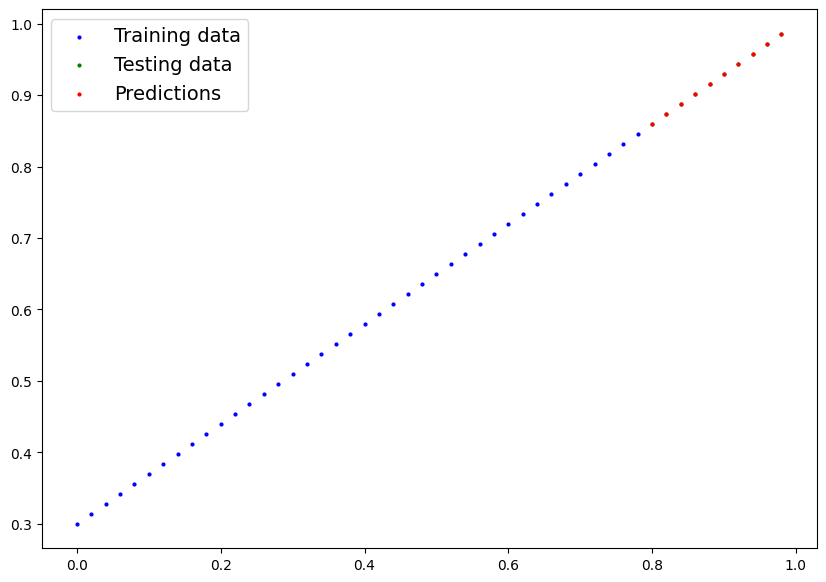

In [200]:
plot_predictions(predictions=y_pred.cpu())

In [201]:
torch.tensor(train_loss_values)

tensor([0.5552, 0.4400, 0.3248, 0.2095, 0.0943, 0.0239, 0.0200, 0.0165, 0.0131,
        0.0097, 0.0062, 0.0028, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013])

In [202]:
torch.Tensor(train_loss_values)


tensor([0.5552, 0.4400, 0.3248, 0.2095, 0.0943, 0.0239, 0.0200, 0.0165, 0.0131,
        0.0097, 0.0062, 0.0028, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013])

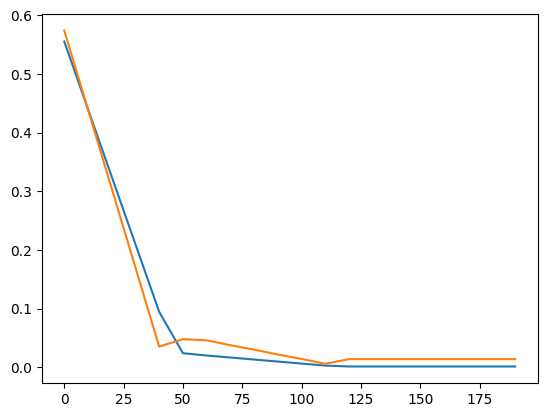

In [203]:
plt.plot(epoch_values, torch.Tensor(train_loss_values))
plt.plot(epoch_values, torch.Tensor(test_loss_values))

### 6.5 Saving & Loading a tarined model

In [204]:
## Saving our PyTorch Model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME= "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH= MODEL_PATH/MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),
           f= MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [205]:
# Load a PyTorch Model

# Create a new instance of Linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# load the saved model_1 state_dict()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put the loaded model to device
loaded_model_1.to(device)


/tmp/ipykernel_3785338/627005074.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [206]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [207]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [208]:
# Evaluate loaded model 
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

In [209]:
y_pred==loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')